<a href="https://colab.research.google.com/github/akshitadixit/Retinopathy/blob/main/resnet50_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import tensorflow.keras as keras

In [3]:
data_root = "/content/gdrive/My Drive/Colab Notebooks/dataset/"

In [4]:
IMG_SIZE = 512

In [19]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-7
WARMUP_LEARNING_RATE = 1e-4
HEIGHT = 256
WIDTH = 256
CANAL = 3
N_CLASSES = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [6]:
import gc
gc.collect()

221

In [20]:
input_tensor = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, CANAL))

base = ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor, input_shape=(HEIGHT, WIDTH, CANAL))
#base.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

top = Dense(N_CLASSES, activation='softmax')(
            Dropout(0.5)(
                Dense(2048, activation='relu')(
                    Dropout(0.5)(
                        GlobalAveragePooling2D()(base.output)
                    )
                )
            )
        )

model = Model(input_tensor, top)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

# training only the top layers
# non-trainable parameters changed from 53210 to 23587712

In [10]:
train = pd.read_pickle(data_root+'train.pkl')
train = shuffle(train)
train, test = np.split(train, [int(.8*len(train))])

In [21]:
# trying image augmentation since to make the model robust, also since training set be very small
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True, vertical_flip=True, rotation_range=0.2, zoom_range=0.2)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_dataframe(dataframe=train,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset = 'training')

valid_generator = train_idg.flow_from_dataframe(dataframe=train,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset = 'validation')

test_generator = test_idg.flow_from_dataframe(dataframe=test,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)


Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [22]:
gc.collect()

732

In [23]:
model.compile(keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
293/293 [==============================] - 76s 235ms/step - loss: 0.8961 - accuracy: 0.6890 - val_loss: 3.2736 - val_accuracy: 0.4932
Epoch 2/2
293/293 [==============================] - 68s 232ms/step - loss: 0.7408 - accuracy: 0.7376 - val_loss: 1.2595 - val_accuracy: 0.5051


In [25]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
293/293 [==============================] - 67s 230ms/step - loss: 0.6494 - accuracy: 0.7607 - val_loss: 0.8712 - val_accuracy: 0.7038
Epoch 2/40
293/293 [==============================] - 67s 229ms/step - loss: 0.5908 - accuracy: 0.7747 - val_loss: 0.5556 - val_accuracy: 0.7877
Epoch 3/40
293/293 [==============================] - 67s 229ms/step - loss: 0.5782 - accuracy: 0.7969 - val_loss: 0.8326 - val_accuracy: 0.7397
Epoch 4/40
293/293 [==============================] - 67s 230ms/step - loss: 0.5315 - accuracy: 0.7995 - val_loss: 0.7772 - val_accuracy: 0.7449
Epoch 5/40
293/293 [==============================] - 67s 228ms/step - loss: 0.5180 - accuracy: 0.7991 - val_loss: 0.7365 - val_accuracy: 0.7003

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/40
293/293 [==============================] - 67s 229ms/step - loss: 0.4608 - accuracy: 0.8208 - val_loss: 0.5136 - val_accuracy: 0.7979
Epoch 7/40
293/293 [=============================

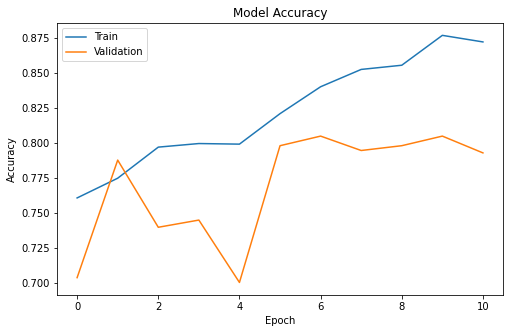

In [27]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()